## GHP Construction with Duration Matching

In [34]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First of all, let's introduce a new function that returns the money generate by "cash flow" bond in each period (not cummulative). In this case, the bond pays some cash in different periods of the year, and when the maturirity is reached, it also returns the initial amount of money invested (here called the principal). Some parameters are assumed, but they can be changed:

In [35]:
erk.bond_cash_flows(3)

1       0.25
2       0.25
3       0.25
4       0.25
5       0.25
6       0.25
7       0.25
8       0.25
9       0.25
10      0.25
11      0.25
12      0.25
13      0.25
14      0.25
15      0.25
16      0.25
17      0.25
18      0.25
19      0.25
20      0.25
21      0.25
22      0.25
23      0.25
24      0.25
25      0.25
26      0.25
27      0.25
28      0.25
29      0.25
30      0.25
31      0.25
32      0.25
33      0.25
34      0.25
35      0.25
36    100.25
dtype: float64

Now let's use a function that tells us the present value of a bound for a coupon rate of 0.05 and a discount rate of 0.04. In principle, we should expect the bond to sell at a premium, as the coupon rate is higher than the discount rate.

In [36]:
erk.bond_price(20,1000,0.05,2,0.04)

0    1136.777396
dtype: float64

On the other hand, if both rates are the same, the present value should match our initial investment.

In [37]:
erk.bond_price(10,100,0.05,2,0.05)

0    100.0
dtype: float64

Let's have a look at different values for the discount rate:

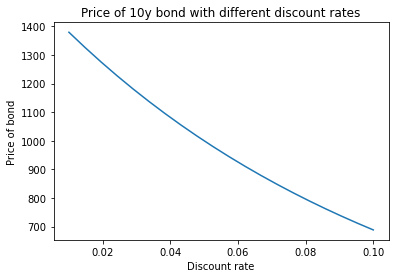

In [38]:
rates = np.linspace(0.01,0.10,20)
prices = [erk.bond_price(10,1000,0.05,2,rate) for rate in rates]
plt.plot(rates,prices)
plt.title("Price of 10y bond with different discount rates")
plt.xlabel("Discount rate")
plt.ylabel("Price of bond")
plt.show()

So if the discount rate goes up, the present value of the bond goes down, which means that it is a bad bond.

Another thing we can do is calculate how much time it would require the bond to return some money with a present value equal to our initial investment (i.e. the face value of the bond), as it gives cash flows periodically. Because of this, we would expect to need less time than the maturity to "recover" our investment. In this case, we will assume that coupon and discount rate are the same:

In [39]:
cf = erk.bond_cash_flows(3,1000,0.06,2)

discounts = erk.discount_simple(cf.index,0.06/2)

dcf = discounts*cf #cashflows must be multiplied by the discounts in each period

weights = dcf/dcf.sum() #because they are discounted, cash flows are not equal, so we must calculate their 
                        #weights 
    
(cf.index*weights).sum() # cf.index is the period in which the cash flow is paid. If we calculate its weighted 
                         # average, we obtain the effective time it takes to obtain a total cash flow with a present 
                         # value of our initial investment

5.579707187194534

So technically, we have to wait 6 semesters (3 years) to receive all the money, but as we've been given some money before the maturity, the weight average duration is lower than 12 semesters (**please, bear in mind that the function introduced by Macauly duration has units of the period in which cash is given, in this case, each semester**). This weighted average duration is called the *Macaulay duration*. If we go to the limit of a zero-coupon bond, the Macauly duration would be 6 years, as there is only one payment. On the other hand, shortening the periodicity of the coupons also shortens the Macauly duration.

We can also use the function we created for this:

In [42]:
erk.macaulay_duration(erk.bond_cash_flows(3,100,0.06,2),0.06/2)

5.579707187194534

### Duration Matching

Let' say we have to liabilities in different period times, 10 and 12 years. We would like to have a portfolio with the same duration as our liabilities. We can treat our liabilities as cash flows that have to be paid by year 10 and 12, so we could find its Macaulay duration.

In [43]:
liabilities = pd.Series(data=[100000,100000],index=[10,12])
erk.macaulay_duration(liabilities,0.04)


10.960799385088393

So we could buy a zero-coupon bond with maturity of 10.96, or two zero-coupon bonds with maturities of 10 and 12. However, this is not always feasible. Imagine that we only have 20-year and 10-year bonds with face value of 1000 dollars and a 5% annual coupon that pay once a year. Let's find their duration:

In [45]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10,1000,0.05,1),.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20,1000,0.05,1),.04)

md_10,md_20


(8.190898824083233, 13.544718122145925)

Now we have to find the weights of these bonds that match a duration of 10.96. That is, 

$$ d_{t} = d_{s}\cdot w + d_{l}\cdot (1-w) $$

So we have that:

$$  w = \frac{d_{l} - d_{t}}{d_{l} - d_{s}} $$

where l and s mean long-duration and short-duration bond. Let's compute the weight:

In [72]:
short_bond = erk.bond_cash_flows(10,1000,0.05,1)
long_bond = erk.bond_cash_flows(20,1000,0.05,1)
w_s = erk.match_durations(liabilities,short_bond,long_bond,0.04)
w_s

0.4826309206947901

So this means that you should put 0.48$\%$ of your money in the short bond and 0.52$\%$ on the long bond. We can check this:

In [73]:
p_short = erk.bond_price(10,1000,0.05,1,0.04)
p_long = erk.bond_price(20,1000,0.05,1,0.04)
a_0= 130000 #initial investment

p_flows = pd.concat([w_s*(a_0/p_short)*short_bond,(1-w_s)*(a_0/p_long)*long_bond]) 
#the flow generated by each bond is the number of bonds you have (initial investment/price) multiplied by its 
#weight in our portfolio and the cash flow of a single bond.

erk.macaulay_duration(p_flows,0.04)

10.960799385088391

Let's calculate now the funding ratio. We should find it to be around 1:

In [89]:
cfr = erk.funding_ratio(p_flows,liabilities,0.04)

In [90]:
cfr

0    0.999876
dtype: float64

Again, let's consider some othr discount rates:

Text(0, 0.5, 'Funding Ratio')

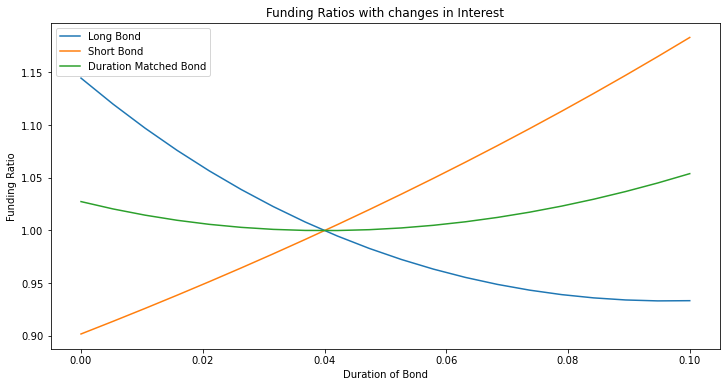

In [103]:
rates = np.linspace(0,.1,20)
lb_assets=(a_0/p_long)*long_bond #cash flow of 100% long bond portfolio
sb_assets = (a_0/p_short)*short_bond #cash flow of 100% short bond portfolio
fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets,liabilities,r) for r in rates],
    "Short Bond": [erk.funding_ratio(sb_assets,liabilities,r) for r in rates],
    "Duration Matched Bond": [erk.funding_ratio(p_flows,liabilities,r) for r in rates]},
    index=rates
)

fr_change.plot(title="Funding Ratios with changes in Interest",figsize=(12,6))

plt.xlabel('Duration of Bond')
plt.ylabel('Funding Ratio')

As we can see, for the weights we calculated with a discount rate of 0.04 (0.48 for short and 0.52 for long), the funding ratio doesn't move very far from 1 (we would have FR of 1 at at discount rate of 0.04). On the other hand, we can see that the funding ratio 100% short/long bond portfolio differs a lot depending on the discount rate.